# Описание проекта

Для оптимизации производственных расходов металлургического комбината на этапе обработки стали, нужно спрогнозировать потребление электроэнергии 

## Исходные данные:

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Цель проекта

Построить модель, которая предскажет температуру стали, что позволит уменьшить потребление электроэнергии на этапе обработки стали. Метрикой качества является MAE.

Необходимо получить на тестовых данных MAE < 6.0

## План проекта

1. Загрузка данных, исследовательский анализ и первичная предобработка
2. Подготовка данных:
    выделение признаков из каждой таблицы, необходимых для модели
    создание и добавление новых признаков
    удаление ненужных данных, если такие будут
3. Сведение всех данных в единую таблицу с целевым признаком по "key"
4. Выбор моделей для обучения, обучение модели с подбором параметров
5. Сравнение результатов, выбор наилучшей модели
6. Тестирование модели и проверка на адекватность
7. Подготовка отчета

######  1. Загрузка и изучение общей информации датасета

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold,train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor



###### Загрузка данных

In [3]:
temp=pd.read_csv('/datasets/data_temp_en.csv')
electrode=pd.read_csv('/datasets/data_arc_en.csv')
bulk=pd.read_csv('/datasets/data_bulk_en.csv')
wire=pd.read_csv('/datasets/data_wire_en.csv')
gas=pd.read_csv('/datasets/data_gas_en.csv')
data_wire_time=pd.read_csv('/datasets/data_wire_time_en.csv')
data_bulk_time=pd.read_csv('/datasets/data_bulk_time_en.csv')

In [4]:
def analyze(data):
    display(data.head())
    display(data.describe())
    data.info()
    print("Пропуски:",data.isna().sum())
    print("Дубликаты:",data.duplicated().sum())

In [5]:
#Функция для построения графиков
def draw(data, parametr, bins=30):
    fig = plt.figure(figsize=(15, 6), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_right = fig.add_subplot(grid[:-1, -1])  
    ax_main.hist(data[parametr], bins, histtype='stepfilled', orientation='vertical')
    ax_right.boxplot(data[parametr])
    ax_right.grid(axis='y')
    ax_main.set(title='Графики по '+parametr)
    plt.show()

###### 1.1  Изучим данные  в датасете temp (результаты измерения температуры)

In [6]:
analyze(temp)

,key,Sampling time,Temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key              15907 non-null int64
Sampling time    15907 non-null object
Temperature      13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
Пропуски: key                 0
Sampling time       0
Temperature      2901
dtype: int64
Дубликаты: 0


В датасете temp  имеется 2901 пропуск  в столбце со значениями температур. Sampling time имеет тип object, нам надо перевести его в тип datetime.

In [7]:
temp['Sampling time']=pd.to_datetime(temp['Sampling time'])

In [8]:
len(temp['key'].unique())

3216

Для 3216 партий имеем значение температуры.

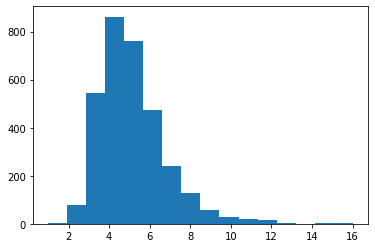

In [9]:
plt.hist((list(temp['key'].value_counts())), bins=16)
plt.show()

Количество итераций варируется от 1 до 16 для каждой партии.

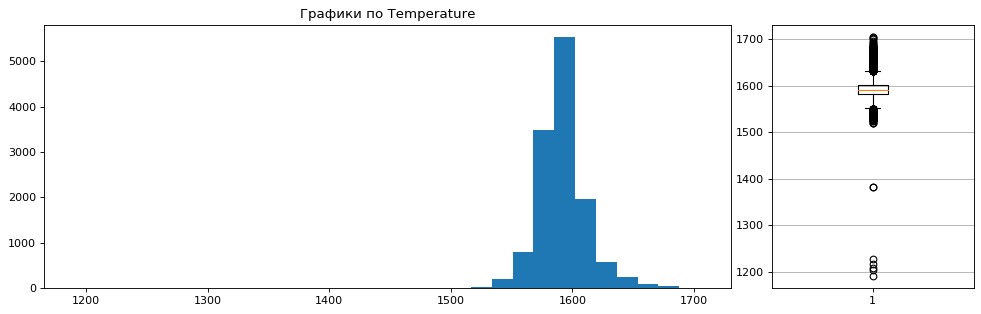

In [10]:
draw(temp.dropna(), 'Temperature')

Видим выбросы и пропуски, но от них пока не будем избавляться, так как время замера связывает таблицу с данными в других таблицах.

In [11]:
temp['key'].value_counts()

44      16
1214    16
1513    16
46      16
1689    15
        ..
1106     2
1424     2
3156     2
279      1
195      1
Name: key, Length: 3216, dtype: int64

Для целевого признака нам нужны минимум 2 значения температуры. Поэтому мы можем удалить данные с 1 значением температуры.

In [12]:
#Удалим все данные о партиях 195 и 279 со всех таблиц
temp = temp.query('key not in (195, 279)')
gas = gas.query('key not in (195, 279)')
bulk = bulk.query('key not in (195, 279)')
wire = wire.query('key not in (195, 279)')

In [13]:
#посмотрим на пропуски в столбце с Температурой
temp[temp['Temperature'].isnull()].head(10)

,key,Sampling time,Temperature
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN


Видим, что начиная с 2500 есть только 1 измерение, поэтому будем использовать партии до 2500 номера.

###### Вывод
В качестве признаков можно использовать для каждого key:

- результат первого измерения температуры
- длительность времени между первым и последним замерами
- общее количество замеров

Целевой признак - результат последнего измерения температуры

###### 1.2 Изучим данные об электродах

In [14]:
analyze(electrode)

,key,Arc heating start,Arc heating end,Active power,Reactive power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Active power,Reactive power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                  14876 non-null int64
Arc heating start    14876 non-null object
Arc heating end      14876 non-null object
Active power         14876 non-null float64
Reactive power       14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
Пропуски: key                  0
Arc heating start    0
Arc heating end      0
Active power         0
Reactive power       0
dtype: int64
Дубликаты: 0


Видим, анамальное минимальное значение реактивной мощности -715. 'Arc heating start'  и 'Arc heating end' приведем к типу datetime. 

In [15]:
electrode['Arc heating start']=pd.to_datetime(electrode['Arc heating start'])
electrode['Arc heating end']=pd.to_datetime(electrode['Arc heating end'])

In [16]:
#Количество партий по количеству уникальных значений 'key'
len(electrode['key'].unique())

3214

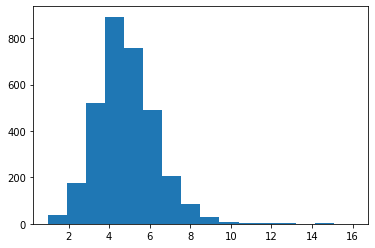

In [17]:
plt.hist((list(electrode['key'].value_counts())), bins=16)
plt.show()

Количество итераций обработки различается для каждой партии от 1 до 16. 

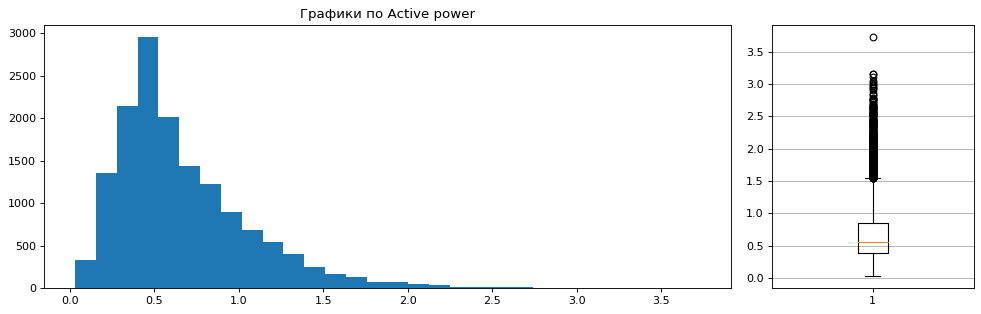

In [18]:
draw(electrode, 'Active power')

Распределение напоминает нормальное со сдвигом влево

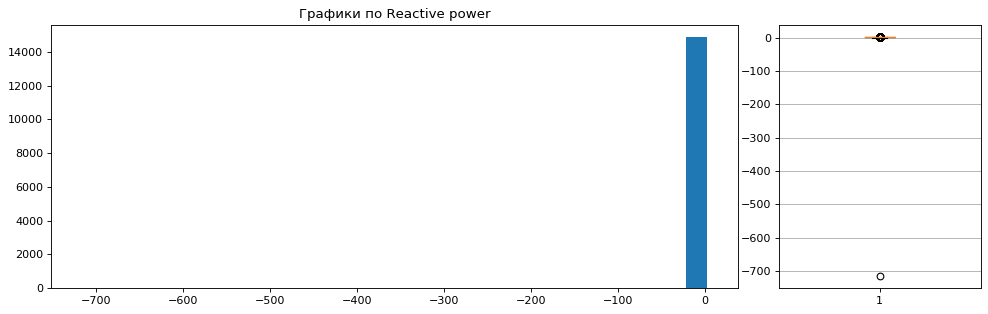

In [19]:
draw(electrode, 'Reactive power')

Аномальное значение реактивной мощности - ошибочное значение. Избавимся от него.

In [20]:
electrode.loc[electrode['Reactive power'] < 0]

,key,Arc heating start,Arc heating end,Active power,Reactive power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [21]:
electrode = electrode[electrode['Reactive power'] > 0]

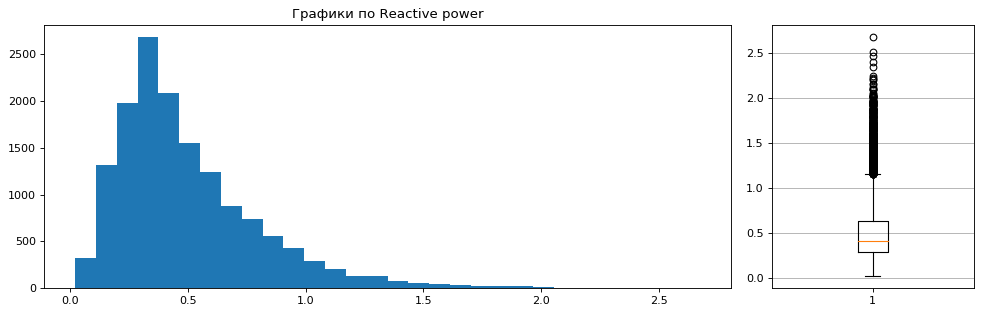

In [22]:
draw(electrode, 'Reactive power')

распределение напоминает нормальное со сдвигом влево

In [23]:
electrode.head(10)

,key,Arc heating start,Arc heating end,Active power,Reactive power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [24]:
#проверим как соотносятся между собой параметры 'Активная мощность' и 'Реактивная мощность'
electrode[['Active power', 'Reactive power']].corr()

,Active power,Reactive power
Active power,1.000000,0.963182
Reactive power,0.963182,1.000000


Видим, что мощности сильно коррелируют друг с другом, поэтому можем ввести понятие о полной мощности. $$ S=\sqrt{P^2+Q^2} $$
где: $P$ — активная мощность, $Q$ — реактивная мощность

In [25]:
def full_power(row):
    full_power = (row['Active power']**2 + row['Reactive power']**2)**0.5
    return full_power

In [26]:
electrode['Full power'] = electrode.apply(full_power, axis=1)

In [27]:
electrode.head(10)

,key,Arc heating start,Arc heating end,Active power,Reactive power,Full power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0.521549
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,1.574162
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,0.577638
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0.975867
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,1.256527


###### Вывод 
В качестве признаков можно использовать для каждого key:

- активную мощность
- реактивную мощность
- полную мощность
- длительность нагрева

###### 1.3 Изучим данные о подаче сыпучих материалов

In [28]:
analyze(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3128.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,575.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.813619,39.242063,253.045455,113.879045,104.394477,107.025974,118.977391,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.176672,18.277654,21.180578,75.483494,48.184126,81.790646,72.109681,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.750000,27.000000,242.000000,58.000000,72.000000,70.000000,69.500000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1623.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.250000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 16 columns):
key        3128 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     575 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 415.4 KB
Пропуски: key           0
Bulk 1     2876
Bulk 2     3106
Bulk 3     1830
Bulk 4     2114
Bulk 5     3051
Bulk 6     2553
Bulk 7     3103
Bulk 8     3127
Bulk 9     3109
Bulk 10    2952
Bulk 11    2951
Bulk 12     678
Bulk 13    3110
Bulk 14     322
Bulk 15     880
dtype: int64
Дубликаты: 0


Большое количество пропусков, есть столбцы, где почти все значения пропущены.

Это объясняется тем, что для каждой партии добавляют опредленное сочетание сыпучих материалов. Поэтому пропуски будем заполнять 0.

In [29]:
#Заполним пустые значения нулями
bulk = bulk.fillna(0)

По объему в среднем больше всего добавляют материалов 12, 14, 15; меньше всего - 13, 9, 8

###### Вывод
В качестве признаков можно использовать для каждого key:

объем по каждому добавленному материалу

In [30]:
analyze(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
Пропуски: key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
Дубликаты: 0


In [31]:
#приведем данные к типу datetime
for i in range(1, 16):
    data_bulk_time[('Bulk %d'%i)] = pd.to_datetime(data_bulk_time[('Bulk %d'%i)] ,format='%Y-%m-%d %H:%M:%S')

###### Вывод
Таблица может служить для связи данных с другими таблицами через общий ключ - время.

###### 1.4 Изучим данные о проволочных материалах

In [32]:
analyze(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3080.000000,3054.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.862987,100.896452,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.833522,42.019385,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.750000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.500000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.250000,126.060485,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3080 entries, 0 to 3080
Data columns (total 10 columns):
key       3080 non-null int64
Wire 1    3054 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 264.7 KB
Пропуски: key          0
Wire 1      26
Wire 2    2001
Wire 3    3017
Wire 4    3066
Wire 5    3079
Wire 6    3007
Wire 7    3069
Wire 8    3061
Wire 9    3051
dtype: int64
Дубликаты: 0


In [33]:
len(wire['key'].unique())

3080

Каждый ключ уникален.

In [34]:
#заполним пропуски нулями
wire = wire.fillna(0)

###### Вывод
В разные партии добавляют разное количество материалов, разный их объем, поэтому пропуски заполнили нулями

В качестве признаков можно использовать для каждого key:

- объем по каждому добавленному материалу

In [35]:
analyze(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
Пропуски: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
Дубликаты: 0


In [36]:
#приведем данные к типу datetime
for i in range(1, 10):
    data_wire_time[('Wire %d'%i)] = pd.to_datetime(data_wire_time[('Wire %d'%i)] ,format='%Y-%m-%d %H:%M:%S')

###### Вывод
Таблица может служить для связи данных с другими таблицами через общий ключ - время.

###### 1.5 Изучим данные о продувке сплава газом

In [37]:
analyze(gas)

,key,Gas 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Gas 1
count,3237.000000,3237.000000
mean,1622.717022,11.006510
std,935.040755,6.219089
min,1.000000,0.008399
25%,814.000000,7.043909
50%,1623.000000,9.836969
75%,2432.000000,13.771959
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3237 entries, 0 to 3238
Data columns (total 2 columns):
key      3237 non-null int64
Gas 1    3237 non-null float64
dtypes: float64(1), int64(1)
memory usage: 75.9 KB
Пропуски: key      0
Gas 1    0
dtype: int64
Дубликаты: 0


In [38]:
#Подсчитаем количество партий, количество уникальных значений параметра key
len(gas['key'].unique())

3237

Каждая партия в таблице встречается только 1 раз, значит это суммарная величина продува со всех этапов.

In [39]:
keys = list(gas['key'])
no_value_gas = []
for i in list(range(1, 3242)):
    if i not in keys:
        no_value_gas.append(i)
no_value_gas

[193, 195, 259, 279]

Отсутствуют данные для партий 193, 195, 259 и 279

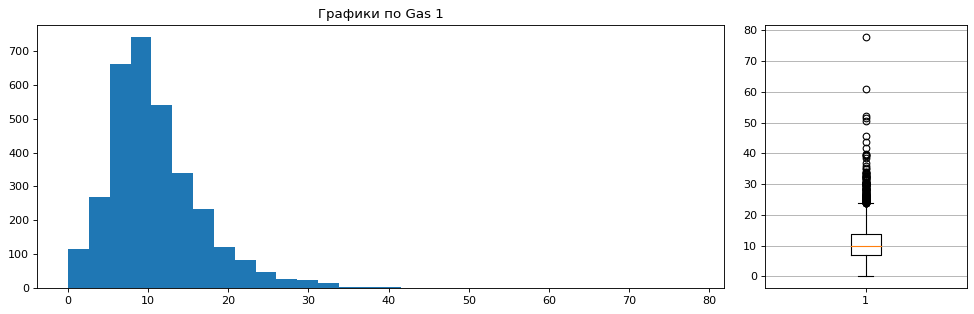

In [40]:
draw(gas, 'Gas 1')

Распределение можно назвать нормальным сдвинутым влево, с пиком на 6-11

###### Вывод
В качестве признаков можно использовать для каждого key:

- общий объем затраченного газа

- Длительность времени между первым и последним замером температуры.

In [41]:
#Время между первым и последним замером
time_diff_temp = (pd.pivot_table(temp[['key', 'Sampling time']], index='key',  aggfunc='max') - pd.pivot_table(temp[['key', 'Sampling time']], index='key',  aggfunc='min'))/np.timedelta64(1, 's')
time_diff_temp.columns = ['Time duration']
time_diff_temp.head()

,Time duration
key,
1,861.0
2,1305.0
3,1300.0
4,388.0
5,762.0


In [42]:
time_diff_temp.describe()

,Time duration
count,3214.000000
mean,1841.006534
std,1246.492874
min,197.000000
25%,1178.250000
50%,1583.000000
75%,2235.000000
max,23537.000000


- Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.

In [43]:
electrode['Heating duration (s)'] = (electrode['Arc heating end'] - electrode['Arc heating start']) // pd.Timedelta('1s')
arc_group = electrode.groupby('key')['Heating duration (s)'].sum().reset_index()
#Начало первого нагрева дугой и окончание последнего нагрева для каждой партии
start = pd.to_datetime(electrode.groupby('key')['Arc heating start'].min()).reset_index()
stop = pd.to_datetime(electrode.groupby('key')['Arc heating end'].max()).reset_index()

#Объединяю данные с признаками start и stop - значения начала первого нагрева дугой и окончания последнего нагрева
arc_group = arc_group.merge(start, on='key')
arc_group = arc_group.merge(stop, on='key')
arc_group.head()

,key,Heating duration (s),Arc heating start,Arc heating end
0,1,1098,2019-05-03 11:02:14,2019-05-03 11:28:37
1,2,811,2019-05-03 11:34:14,2019-05-03 11:53:18
2,3,655,2019-05-03 12:06:54,2019-05-03 12:32:19
3,4,741,2019-05-03 12:39:37,2019-05-03 12:57:50
4,5,869,2019-05-03 13:11:13,2019-05-03 13:33:55


In [44]:
arc_group.describe()

,key,Heating duration (s)
count,3214.000000,3214.000000
mean,1623.061294,794.545115
std,934.739859,332.491076
min,1.000000,57.000000
25%,817.250000,571.000000
50%,1623.500000,770.000000
75%,2431.750000,983.000000
max,3241.000000,4189.000000


- Количество запусков нагрева электродами.

In [45]:
total_count_arc = electrode['key'].value_counts().sort_index().reset_index().rename(columns={"index": "key", "key": "Arc count"})

In [46]:
total_count_arc.head()

,key,Arc count
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4


In [47]:
total_count_arc.describe()

,key,Arc count
count,3214.000000,3214.000000
mean,1623.061294,4.628189
std,934.739859,1.608866
min,1.000000,1.000000
25%,817.250000,4.000000
50%,1623.500000,4.000000
75%,2431.750000,6.000000
max,3241.000000,16.000000


- Среднее соотношение потребления активной и реактивной мощности.

In [48]:
#Среднее соотношениеё активных и реактивных мощностей в каждой партии
power_mean = electrode.groupby('key')['Active power', 'Reactive power'].mean().reset_index().rename(columns={"Active power": "Mean active power", "Reactive power": "Mean reactive power"})

In [49]:
power_mean.head()

,key,Mean active power,Mean reactive power
0,1,0.975629,0.636648
1,2,0.763150,0.499528
2,3,0.505176,0.319815
3,4,0.802313,0.515074
4,5,0.836793,0.563161


In [50]:
power_mean.describe()

,key,Mean active power,Mean reactive power
count,3214.000000,3214.000000,3214.000000
mean,1623.061294,0.671067,0.501532
std,934.739859,0.207490,0.153933
min,1.000000,0.186226,0.130062
25%,817.250000,0.519691,0.387213
50%,1623.500000,0.646633,0.489478
75%,2431.750000,0.797201,0.599788
max,3241.000000,1.819169,1.141721


In [51]:
#Сумма активных и реактивных мощностей в каждой партии
power_sum = electrode.groupby('key')['Active power', 'Reactive power'].sum().reset_index().rename(columns={"Active power": "Mean active power", "Reactive power": "Mean reactive power"})

###### 2 Подготовка данных

In [52]:
#Поcле 2500 партии значения температуры есть только для первого измерения. Поэтому будем использовать только партии до 2500 номера.
temp = temp.query('key < 2500')
electrode = electrode.query('key < 2500')
bulk = bulk.query('key < 2500')
wire = wire.query('key < 2500')

In [53]:
#Время последнего измерения для каждой партии
#Последнее значение температуры = data_temp.sort_values('Время замера').groupby('key').last()['Температура']
last_time_temp = pd.to_datetime(temp.groupby('key')['Sampling time'].max())
#Время последнего измерения и значение температуры в каждой партии
temp_target = temp.merge(last_time_temp, on="Sampling time").rename(columns={"Sampling time": "Last time", "Temperature": "Last temperature"})

In [54]:
temp_target.head(10)

,key,Last time,Last temperature
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0
5,6,2019-05-03 14:12:29,1596.0
6,7,2019-05-03 14:42:37,1599.0
7,8,2019-05-03 15:22:52,1598.0
8,9,2019-05-03 16:01:16,1592.0
9,10,2019-05-03 16:36:08,1593.0


In [55]:
#Время первого измерения для каждой партии
first_time_temp = pd.to_datetime(temp.groupby('key')['Sampling time'].min())
#Время первого измерения и значение температуры в каждой партии
temp_first = temp.merge(first_time_temp, on="Sampling time").rename(columns={"Sampling time": "First time", "Temperature": "First temperature"})

In [56]:
temp_first.head()

,key,First time,First temperature
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0


In [57]:
#Количество замеров Температуры
total_count_temp = pd.pivot_table(temp[['key', 'Temperature']],index='key',  aggfunc='count')
total_count_temp.columns = ['Temperature count']

In [58]:
total_count_temp.head()

,Temperature count
key,
1,5
2,6
3,5
4,3
5,2


###### 3 Сведение всех данных в одну таблицу

In [59]:
data_final = gas.merge(temp_target, on='key')
#Добавляю данные с временем первого измерения и значениями температуры
data_final = data_final.merge(temp_first, on='key')
data_final = data_final.merge(time_diff_temp, on='key')
data_final = data_final.merge(total_count_temp, on='key')

In [60]:
#Добавляю данные с количеством итераций в каждой партии
data_final = data_final.merge(total_count_arc, on='key')
#Добавляю данные с суммарной активной и реактивной мощностями
data_final = data_final.merge(power_sum, on='key')
#Добавляю данные с временем начала первого нагрева дугой, окончанием последнего нагрева и общим временем нагрева для каждой партии
data_final = data_final.merge(arc_group, on='key')

In [61]:
#Создаю признаки с длительностью времени от начала нагрева дугой в секундах
data_final['delta1'] = (data_final['First time'] - data_final['Arc heating start']) // pd.Timedelta('1s')
data_final['delta2'] = (data_final['Arc heating end'] - data_final['Arc heating start']) // pd.Timedelta('1s')
data_final['delta3'] = (data_final['Last time'] - data_final['Arc heating start']) // pd.Timedelta('1s')

In [62]:
#Добавляю данные о подачи сыпучих материалов и проволоки
data_final = data_final.merge(bulk, on='key')
data_final = data_final.merge(wire, on='key')

In [63]:
#Удалим признаки со временем и key
data_final = data_final.drop(['key', 'Arc heating start', 'Arc heating end', 'First time', 'Last time'], axis=1)

In [64]:
analyze(data_final)

,Gas 1,Last temperature,First temperature,Time duration,Temperature count,Arc count,Mean active power,Mean reactive power,Heating duration (s),delta1,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,29.749986,1613.0,1571.0,861.0,5,5,4.878147,3.183241,1098,844,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.555561,1602.0,1581.0,1305.0,6,4,3.052598,1.998112,811,193,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28.554793,1599.0,1596.0,1300.0,5,5,2.525882,1.599076,655,383,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.841219,1625.0,1601.0,388.0,3,4,3.209250,2.060298,741,800,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.413692,1602.0,1576.0,762.0,2,4,3.347173,2.252643,869,726,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Gas 1,Last temperature,First temperature,Time duration,Temperature count,Arc count,Mean active power,Mean reactive power,Heating duration (s),delta1,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2329.000000,2329.000000,2329.000000,2329.00000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,2329.000000,2329.000000,2329.000000
mean,11.375600,1593.365393,1586.718763,1898.98669,4.984543,4.695148,3.152236,2.351068,807.600687,277.710176,...,119.952769,102.443601,17.609859,3.234916,0.306550,0.0,0.978820,0.006361,0.311311,0.317113
std,6.392041,11.200915,28.290792,1322.09781,1.796981,1.606948,1.425522,1.081806,340.897332,178.811862,...,84.640443,43.539993,33.624771,27.942871,4.757746,0.0,8.693299,0.205705,4.402707,3.456561
min,0.008399,1541.000000,1191.000000,234.00000,2.000000,1.000000,0.186226,0.158247,57.000000,-1149.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,7.282948,1587.000000,1571.000000,1215.00000,4.000000,4.000000,2.173277,1.626854,581.000000,191.000000,...,0.000000,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,10.100950,1593.000000,1587.000000,1635.00000,5.000000,5.000000,3.028334,2.234997,778.000000,231.000000,...,107.000000,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,14.216688,1598.000000,1603.000000,2292.00000,6.000000,6.000000,3.920676,2.915089,993.000000,301.000000,...,204.000000,128.091599,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,77.995040,1653.000000,1660.000000,23537.00000,16.000000,16.000000,17.496497,12.587990,4189.000000,2433.000000,...,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 36 columns):
Gas 1                   2329 non-null float64
Last temperature        2329 non-null float64
First temperature       2329 non-null float64
Time duration           2329 non-null float64
Temperature count       2329 non-null int64
Arc count               2329 non-null int64
Mean active power       2329 non-null float64
Mean reactive power     2329 non-null float64
Heating duration (s)    2329 non-null int64
delta1                  2329 non-null int64
delta2                  2329 non-null int64
delta3                  2329 non-null int64
Bulk 1                  2329 non-null float64
Bulk 2                  2329 non-null float64
Bulk 3                  2329 non-null float64
Bulk 4                  2329 non-null float64
Bulk 5                  2329 non-null float64
Bulk 6                  2329 non-null float64
Bulk 7                  2329 non-null float64
Bulk 8                  2329 no

In [65]:
#Разделим данные на обучающую и тестовую выборки в соотношении 75/25
features = data_final.drop('Last temperature', axis=1)
target = data_final['Last temperature']

In [66]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, shuffle=False, random_state=12345)

In [67]:
#Проведем масштабирование
sc = StandardScaler().fit(features_train)
features_train_scaled = sc.transform(features_train)
features_test_scaled = sc.transform(features_test)

In [68]:
#Подбор гиперпараметров с кросс-валидацией на 5 подвыборках
kf = KFold(n_splits=5, shuffle=False, random_state=12345)

In [69]:
final_score={}

###### 4.1 RandomForestRegressor

In [70]:
rfr_param = {'n_estimators': np.arange(300, 700, 100), 
            'max_depth': np.arange(3, 7),
            'min_samples_split': np.arange(2, 10, 2)}
gs_rfr = GridSearchCV(RandomForestRegressor(random_state=12345), rfr_param, refit=False, cv=kf, scoring='neg_mean_absolute_error') 
gs_rfr.fit(features_train_scaled, target_train)
print('MAE на кросс-валидации: ', abs(gs_rfr.best_score_))
params = gs_rfr.best_params_
rfr = RandomForestRegressor(**params, random_state=12345)
rfr.fit(features_train_scaled, target_train)
pred_test = rfr.predict(features_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(target_test, pred_test))

MAE на кросс-валидации:  6.283669613667162
{'max_depth': 6, 'min_samples_split': 6, 'n_estimators': 400}
MAE на тестовой выборке:  6.15984140891743


In [71]:
final_score['RandomForestRegressor'] = [abs(gs_rfr.best_score_), mean_absolute_error(target_test, pred_test), params]

###### 4.2 LGBMRegressor

In [72]:
lgbm_param = {'n_estimators': np.arange(300, 700, 100), 
              'learning_rate': np.arange(0.02, 0.12, 0.02),
              'max_depth': np.arange(3, 7)}
gs_lgbm = GridSearchCV(lgb.LGBMRegressor(random_state=12345), lgbm_param, cv=kf, scoring='neg_mean_absolute_error', refit=False) 
gs_lgbm.fit(features_train_scaled, target_train)
print('MAE на кросс-валидации: ', abs(gs_lgbm.best_score_))
params = gs_lgbm.best_params_
lgbm = lgb.LGBMRegressor(**params, random_state=12345)
lgbm.fit(features_train_scaled, target_train)
pred_test = lgbm.predict(features_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(target_test, pred_test))

MAE на кросс-валидации:  5.764190411270862
{'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 400}
MAE на тестовой выборке:  5.73645198376683


In [73]:
final_score['LGBMRegressor'] = [abs(gs_lgbm.best_score_), mean_absolute_error(target_test, pred_test), params]

###### 4.3 CatBoostRegressor

In [74]:
ctb_param = {'n_estimators': np.arange(300, 700, 100),  
             'learning_rate': np.arange(0.02, 0.12, 0.02),
             'depth': np.arange(3, 7)}
gs_ctb = GridSearchCV(CatBoostRegressor(random_state=12345, silent=True), ctb_param, cv=kf, scoring='neg_mean_absolute_error', refit=False) 
gs_ctb.fit(features_train_scaled, target_train)
print('MAE на кросс-валидации: ', abs(gs_ctb.best_score_))
params = gs_ctb.best_params_
ctb = CatBoostRegressor(**params, random_state=12345, silent=True)
ctb.fit(features_train_scaled, target_train)
pred_test = ctb.predict(features_test_scaled)
print(params)
print("MAE на тестовой выборке: ", mean_absolute_error(target_test, pred_test))

MAE на кросс-валидации:  5.55466499612371
{'depth': 6, 'learning_rate': 0.06, 'n_estimators': 600}
MAE на тестовой выборке:  5.479675541265396


In [75]:
final_score['CatBoostRegressor'] = [abs(gs_ctb.best_score_), mean_absolute_error(target_test, pred_test), params]

###### 5 Сравнение результатов и выбор наилучшей модели

,MAE на кросс-валидации,MAE на тестовой выборке,Лучшие параметры
RandomForestRegressor,6.283670,6.159841,"{'max_depth': 6, 'min_samples_split': 6, 'n_es..."
LGBMRegressor,5.764190,5.736452,"{'learning_rate': 0.02, 'max_depth': 6, 'n_est..."
CatBoostRegressor,5.554665,5.479676,"{'depth': 6, 'learning_rate': 0.06, 'n_estimat..."


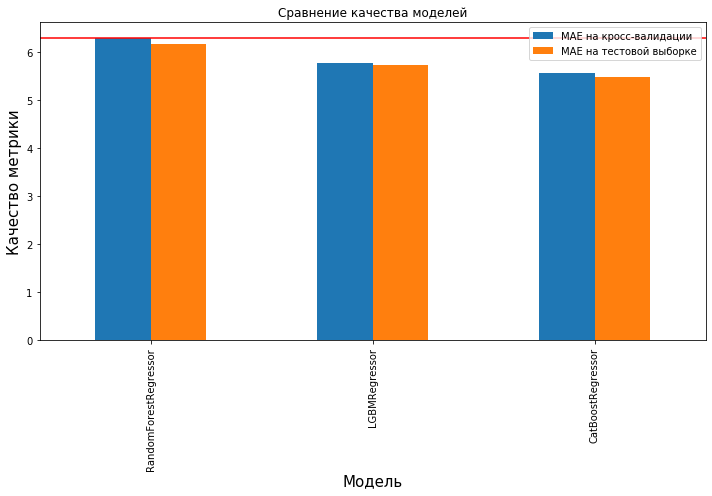

In [76]:
data_final_score = pd.DataFrame.from_dict(data=final_score, columns=['MAE на кросс-валидации', 'MAE на тестовой выборке', 'Лучшие параметры'], orient='index')
display(data_final_score)

plt.figure(figsize=(10, 7))
plt.subplot(111)
data_final_score.plot(kind='bar', ax=plt.gca()).hlines(6.3, -1, 5, color = 'r')
plt.xlabel('Модель', fontsize=15)
plt.ylabel('Качество метрики', fontsize=15)
plt.title('Сравнение качества моделей')

plt.tight_layout()

###### Вывод

Видим, что самой лучшей моделью с минимальным значением МАЕ и на кросс-валидации(5.55) и на тестовой выборке(5.47) оказалась CatBoostRegressor с гиперпараметрами {'depth': 6, 'learning_rate': 0.06, 'n_estimators': 600} , чуть хуже значения (5.76, 5.73) дала LGBMRegressor с гиперпараметрами {'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 400} и самый худший результат в этой тройке - RandomForestRegressor (6.28, 6.15) с гиперпараметрами {'max_depth': 6, 'min_samples_split': 6, 'n_estimators': 400}.

###### 6 Тестирование модели и проверка на адекватность

In [77]:
#Рассчитаем метрику MAE для константной модели, в качестве предсказания возьмем среднее значение финальной температуры для обучающего набора данных.
mean_temp = pd.Series(target_train.mean(), index=target_test.index)
print("MAE константной модели: ", mean_absolute_error(target_test, mean_temp))

MAE константной модели:  8.410499666967278


###### Вывод
Все наши модели предсказывают лучше, чем константная.

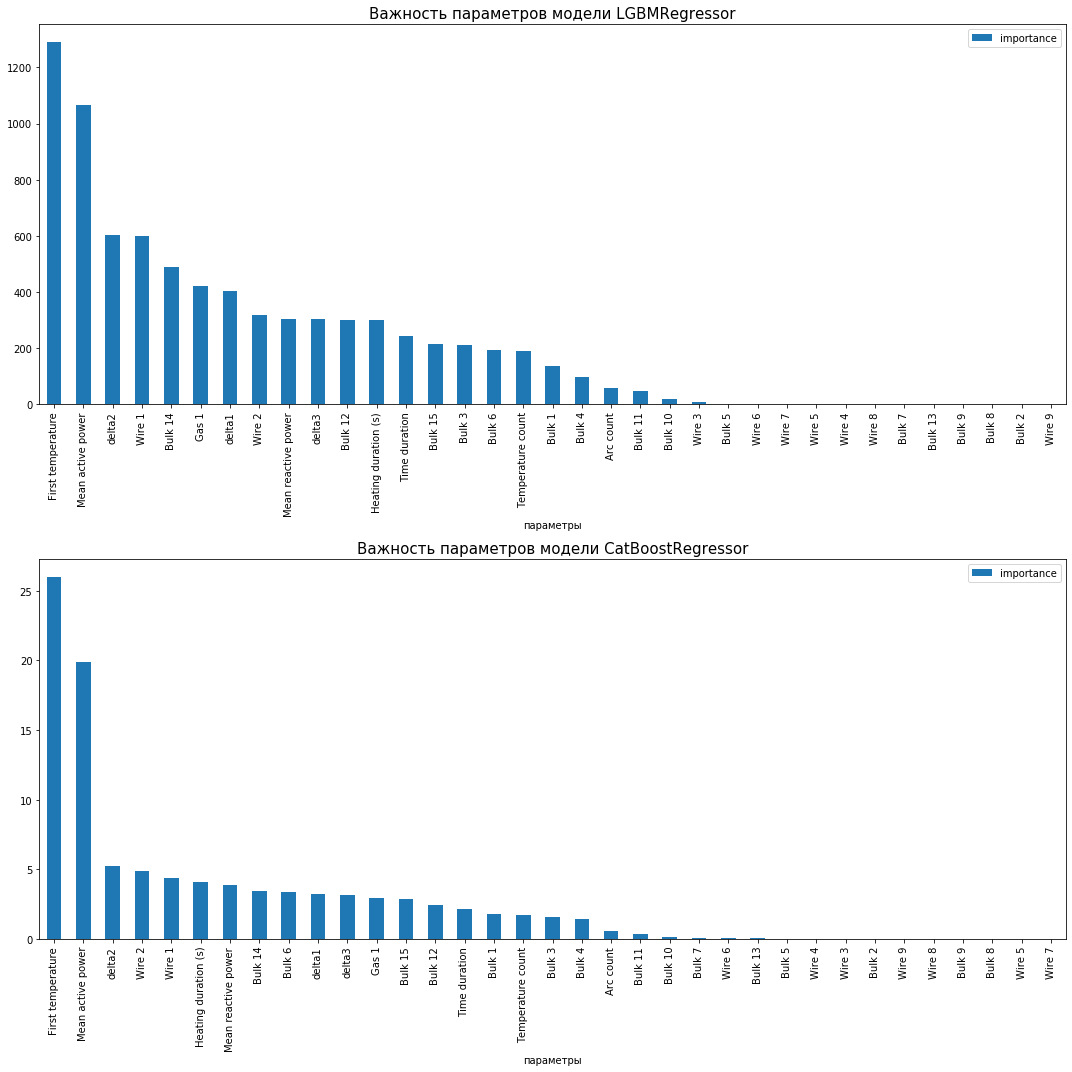

In [78]:
#посмотрим важность параметров моделей
importance_lgbm = (pd.DataFrame({'feature': features_train.columns, 'importance': lgbm.fit(features_train_scaled, target_train).feature_importances_}).sort_values(by='importance', ascending=False).reset_index())
importance_ctb = (pd.DataFrame({'feature': features_train.columns, 'importance': ctb.fit(features_train_scaled, target_train).feature_importances_}).sort_values(by='importance', ascending=False).reset_index())
plt.figure(figsize=(15, 15))
plt.subplot(211)           
importance_lgbm.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), sharex=False)
plt.xlabel('параметры')
plt.title('Важность параметров модели LGBMRegressor', fontsize=15)
plt.subplot(212)    
importance_ctb.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), sharex=False)
plt.xlabel('параметры')
plt.title('Важность параметров модели CatBoostRegressor', fontsize=15)
plt.tight_layout()


Для лучших моделей CatBoostRegressor и LGBMRegressor важность признаков расположена в разном порядке, но "Первое значение температуры" и "Сумма активной мощности" наиболее важны в обоих моделях.

# Отчет

- Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Все пункты плана были выполнены.

- Какие трудности возникли и как вы их преодолели?

Было сложно вникнуть в сам производственный процесс. Также нужно было рассмотреть несколько датасетов и создать одну общую базу для построения моделей. Я решила оставить большинство признаков за исключением key  и временных, поэтому и возник вопрос о мультиколлениарности и важности каждого признака для моделей.

- Какие ключевые шаги в решении задачи выделили?

1.  Исследовательсткий анализ и предобработка данных.
2. Выделение признаков и объединение в итоговую таблицу.
3. Обучение моделей и анализ результатов

- Какая ваша итоговая модель и какое у неё качество?

На тестовой выборке лучший результат MAE у модели CatBoostRegressor 5.47 с гиперпараметрами {'depth': 6, 'learning_rate': 0.06, 'n_estimators': 600} 